In [1]:
# %pip install -Uqqq pip --progress-bar off
# %pip install -qqq ollama --progress-bar off


# %pip install -qqq owlready2 --progress-bar off

# %pip install -qqq langchain-ollama --progress-bar off
# %pip install -qqq langchain-community --progress-bar off
# %pip install -qqq pypdf --progress-bar off

# %pip install -qqq faiss-cpu --progress-bar off
# %pip install -qqq rank_bm25 --progress-bar off
# %pip install -qqq fuzzywuzzy --progress-bar off
# %pip install -qqq scikit-learn --progress-bar off
# %pip install -qqq sentence-transformers --progress-bar off
# %pip install -qqq pandas --progress-bar off
# %pip install -qqq matplotlib --progress-bar off
# %pip install -qqq seaborn --progress-bar off


In [2]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain_ollama import OllamaEmbeddings
import ollama
import json
from enum import Enum
import json
import re
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain.chat_models import ChatOllama
from owlready2 import *
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from fuzzywuzzy import fuzz
from langchain.vectorstores import FAISS
from langchain.retrievers import EnsembleRetriever, BM25Retriever, MultiQueryRetriever
from langchain.embeddings import OllamaEmbeddings

d:\Rohit\Dev\Generating_KG_from_LLMs\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Rohit\Dev\Generating_KG_from_LLMs\.venv\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
# Initialize the SentenceTransformer model
entity_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

MODEL = "deepseek-r1:8b-llama-distill-q8_0"

file_path ="PDFs/MEMSPressureSensors.pdf"

file_name = file_path.split('/')[-1].split('.')[0]
response_path = 'responses/R1_temp_responses_{file}.json'.format(file=file_name)
generated_path = 'generated_JSON/R1_temp_generated_{file}.json'.format(file=file_name)
ontology_path = 'ontology/R1_temp_ontology_{file}.owl'.format(file=file_name)
validation_json_path = 'QA/R1_temp_validation_{file}.json'.format(file=file_name)

In [4]:
def clean_text(text):
    # Remove LaTeX equations
    text = re.sub(r'\$.*?\$', '', text)  # Remove inline equations
    # Fix hyphenated words
    text = re.sub(r'(\w+)-\n(\w+)', r'\1\2', text)
    # Remove excessive whitespace
    return re.sub(r'\s+', ' ', text).strip()

In [5]:
# Load the PDF
pdf_loader = PyPDFLoader(file_path=file_path,extract_images=False)
docs = pdf_loader.load();
# Enhanced cleaning pipeline
for doc in docs:
    doc.page_content = clean_text(doc.page_content)

In [6]:
def analyze_splits(splits):
    stats = {
        'total_chunks': len(splits),
        'avg_chunk_length': sum(len(c.page_content) for c in splits)/len(splits),
        'max_length': max(len(c.page_content) for c in splits),
        'min_length': min(len(c.page_content) for c in splits),
        'metadata_fields': list(splits[0].metadata.keys()) if splits else []
    }
    return stats

In [7]:
text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500,
        chunk_overlap=50,
        length_function=lambda text: len(text.split()),  # Word-based counting
        add_start_index=True,
       separators=[
        "\n\n## ",    # Section headers
        "\n\n",       # Paragraph breaks
        "\n",         # New lines
        "(?<!\d)\.(?!\d)\s+",  # Sentence ends with space
        ";",          # Semi-colons
        ", ",         # Commas
        " "
        ],
        keep_separator=True,
        is_separator_regex=True,
    )

splits = text_splitter.split_documents(docs)
analyze_splits(splits)

{'total_chunks': 47,
 'avg_chunk_length': 2340.5106382978724,
 'max_length': 3678,
 'min_length': 445,
 'metadata_fields': ['producer',
  'creator',
  'creationdate',
  'author',
  'keywords',
  'moddate',
  'subject',
  'title',
  'source',
  'total_pages',
  'page',
  'page_label',
  'start_index']}

In [8]:
# Step 1: Store Embeddings in FAISS (Faster Retrieval)
embeddings = OllamaEmbeddings(model=MODEL)
faiss_store = FAISS.from_documents(splits, embeddings)

# Step 2: Set Up Retrieval Methods
vector_retriever = faiss_store.as_retriever(search_kwargs={"k": 3})
bm25_retriever = BM25Retriever.from_documents(splits)
bm25_retriever.k = 3  # Match vector retriever

# Dynamic Weights for Different Queries
query_type = "entity"  # or "relation"
weights = [0.8, 0.2] if query_type == "entity" else [0.6, 0.4]

# Ensemble Retriever
retriever = EnsembleRetriever(
    retrievers=[vector_retriever, bm25_retriever],
    weights=weights
)
llm = ChatOllama(model=MODEL) 
# Multi-Query Expansion (Better Recall)
mq_retriever = MultiQueryRetriever.from_llm(retriever=retriever, llm=llm)

# Retrieve Once, Then Filter
combined_query = """
EXTRACT: Information about sensors, including their names or models, types (e.g., pressure, temperature, ultrasonic, optical, capacitive, MEMS), components, technical specifications (properties with units), and their applications or the devices they are part of.
FIND: Key details describing sensor characteristics, measurement principles, functionality, design, and context of use.
FOCUS: Sections explicitly discussing sensor technology, design, specifications, fabrication, or experimental setups involving specific sensors.
IGNORE: General discussion without specific sensor details, citation markers, author names, affiliations.
"""

retrieved_docs = mq_retriever.get_relevant_documents(combined_query)

retrieved_text = "\n\n".join([doc.page_content for doc in retrieved_docs])

C:\Users\rohit\AppData\Local\Temp\ipykernel_2572\1622220240.py:2: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaEmbeddings``.
  embeddings = OllamaEmbeddings(model=MODEL)
C:\Users\rohit\AppData\Local\Temp\ipykernel_2572\1622220240.py:19: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  llm = ChatOllama(model=MODEL)
C:\Users\rohit\AppData\Local\Temp\ipykernel_2572\1622220240.py:31: LangChainDeprec

In [9]:
# Initialize with your local model
compressor = LLMChainExtractor.from_llm(llm=llm)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=retriever,
    search_kwargs={"k": 10}  
)

In [10]:
KG_EXTRACTION_PROMPT = """
As an expert analyst specializing in extracting information about sensor technology from technical documents, analyze the provided text to identify and structure data about sensors.

**Target Entities**:
1. Sensor Name/Model: The specific name, model number, or descriptive identifier of the sensor (e.g., CMUT pressure sensor, PT-1000, Velodyne VLP-16, F8-type sensor). Extract the most specific identifier available.
2. Category: The general type or classification of the sensor (e.g., Capacitive Pressure Sensor, Temperature Sensor, LiDAR, Ultrasonic Transducer, MEMS Sensor, Optical Sensor).
3. Components: Physical or functional parts of the sensor (e.g., MEMS diaphragm, silicon substrate, TSV, laser diode, photodetector).
4. Properties/Specifications: Quantifiable characteristics or performance metrics, often with units (e.g., sensitivity: 34 fF/kPa, range: 0-10 Bar, accuracy: ±0.01 Bar, resolution: 0.2°, wavelength: 905 nm, operating temperature: up to 350 °C). Also include qualitative properties derived from context (e.g., comparative_sensitivity: > Sensor B).
5. Implementations/Standards: Any specific standards, protocols, or notable techniques implemented or used by the sensor (e.g., silicon-silicon bonding, TSV technology, ROS2, I2C).
6. Device/Application: The larger system, device, or application area the sensor is used in (e.g., Tire Pressure Monitoring System (TPMS), autonomous vehicles, industrial process control, environmental monitoring).

**Extraction Rules**:
- Faithfully represent information stated in the text.
- Preserve contextual relationships. Link components, properties, implementations, and applications directly to the specific sensor they relate to.
  *Example for Guidance Only (Do NOT include this data in your output)*: "The Model XYZ pressure sensor uses a MEMS diaphragm to detect changes up to 10 Bar" -> {{"name": "Model XYZ", "category": "Pressure Sensor", "parts": ["MEMS diaphragm"], "properties": ["pressure range: up to 10 Bar"]}}
- Capture implied properties from comparisons.
  *Example for Guidance Only (Do NOT include this data in your output)*: "Sensor A is more sensitive than Sensor B" -> {{"properties": ["comparative_sensitivity: > Sensor B"]}}
- Identify the devices or applications associated with sensors.
- Prioritize extracting specific, named sensors or clearly described sensor types. Avoid vague references like "a sensor" unless no other identifier is available in the context.

**Format**: Output ONLY the JSON object following this structure.
{{
  "sensors": [
    {{
      "name": "",
      "category": "",
      "parts": [],
      "properties": [],
      "implements": [],
      "device": ""
    }}
    // Add more sensor objects if multiple are found
  ]
}}

**Critical Instructions**:
1. If no specific sensors or sensor types are clearly identified in the text, return: {{"sensors": []}}
2. Only include sensor information that is explicitly mentioned or directly implied in the provided text.
3. Do not invent information or include data from the guidance examples in your output.
4. Ensure the output is ONLY the valid JSON object, with no additional text, commentary, or explanations before or after it.
5. Use exact names and values from the text whenever possible for properties and specifications.

<text> {text} </text>
"""

In [11]:
class ResponseFormat(Enum):
    JSON = "json_object"
    TEXT = "text"
 
 
def call_model(
    prompt: str, response_format: ResponseFormat = ResponseFormat.TEXT
) -> str:
    response = ollama.generate(
        model=MODEL,
        prompt=prompt,
        keep_alive="1h",
        format="" if response_format == ResponseFormat.TEXT else "json",
    )
    return response["response"]

In [12]:
chunks = text_splitter.split_text(retrieved_text)


In [13]:
# Prepare the final prompt with the concatenated text

responses = []

for chunk in chunks:
        final_prompt = KG_EXTRACTION_PROMPT.format(text=chunk)
        # Send the final prompt to Ollama
        # print (final_prompt)
        response = call_model(final_prompt)
        responses.append(response)

In [14]:


#Save responses after every chunk to ensure progress is retained
with open(response_path, "w", encoding="utf-8") as f:
    json.dump(responses, f)

In [15]:
import json
import unicodedata
import re

def clean_string(s):
    """
    Clean and normalize strings by stripping whitespace, decoding unicode escapes,
    normalizing characters, replacing common separators with a space, and fixing known encoding issues.
    """
    if not isinstance(s, str):
        return str(s).lower()
    s = s.strip()
    s = unicodedata.normalize('NFKC', s)
    s = s.replace("â", "")
    s = s.replace('<', ',')
    s = s.replace('>', ',')
    return s.lower() 

def make_valid_iri_fragment(s):
    """
    Generate a valid IRI fragment from a string by first cleaning it and then
    replacing spaces with underscores and removing disallowed characters.
    """
    cleaned = clean_string(s)
    # Replace spaces with underscores.
    cleaned = cleaned.replace(" ", "_")
    # Remove any characters that are not alphanumerics, underscores, or hyphens.
    cleaned = re.sub(r"[^A-Za-z0-9_\-]", "", cleaned)
    return cleaned


def extract_json_part(response_str):
    """
    Extract the JSON block from Ollama's response string.
    Tries to find the JSON block delimited by ```json and ```.
    """
    try:
        json_str = response_str.split("```json")[-1].split("```")[0].strip()

        return json.loads(json_str)
    except (IndexError, json.JSONDecodeError) as e:
        print(f"Failed to extract JSON: {str(e)}")
        return None

# Load responses from file
with open(response_path, "r", encoding="utf-8") as f:
    raw_data = f.read()

# Try parsing as a full JSON array; if that fails, split by lines.
try:
    responses = json.loads(raw_data)
except json.JSONDecodeError:
    responses = [json.loads(line) for line in raw_data.splitlines() if line.strip()]



In [16]:
# Use a dictionary keyed solely on sensor name
sensor_dict = {}

for response in responses:
    # If the response is not a dict, try extracting the JSON block
    if not isinstance(response, dict):
        extracted = extract_json_part(response)
        if extracted is None:
            continue
        response = extracted

    if isinstance(response, list):
        continue
    sensors = response.get("sensors", [])
    if not isinstance(sensors, list):
        continue

    for sensor in sensors:
        # Clean and extract fields from the sensor entry
        sensor_name = clean_string(sensor.get("name", "unnamed sensor"))
        if not sensor_name:
            continue
        category_name = clean_string(sensor.get("category", "uncategorized"))
        parts_list = sensor.get("parts", [])
        properties_list = sensor.get("properties", [])
        implements_list = sensor.get("implements", [])
        # Note: if your field is "devices" (plural), adjust accordingly
        device_info = clean_string(sensor.get("device", "")) or ""
        
        cleaned_parts = set(clean_string(p) for p in parts_list if p)
        cleaned_properties = set(clean_string(p) for p in properties_list if p)
        cleaned_implements = set(clean_string(i) for i in implements_list if i)
        devices = set()
        if device_info:
            devices.add(device_info)
        
        # Use sensor_name as the key for merging
        key = sensor_name
        
        if key in sensor_dict:
            sensor_dict[key]["category"].add(category_name)
            sensor_dict[key]["parts"].update(cleaned_parts)
            sensor_dict[key]["properties"].update(cleaned_properties)
            sensor_dict[key]["implements"].update(cleaned_implements)
            sensor_dict[key]["devices"].update(devices)
        else:
            sensor_dict[key] = {
                "name": sensor_name,
                "category": {category_name},
                "parts": cleaned_parts,
                "properties": cleaned_properties,
                "implements": cleaned_implements,
                "devices": devices
            }

# Convert sets to sorted lists and merge categories into a single string
final_sensors = []
for sensor in sensor_dict.values():
    sensor["category"] = ", ".join(sorted(sensor["category"]))
    sensor["parts"] = sorted(sensor["parts"])
    sensor["properties"] = sorted(sensor["properties"])
    sensor["implements"] = sorted(sensor["implements"])
    sensor["devices"] = sorted(sensor["devices"])
    final_sensors.append(sensor)

# Save the deduplicated JSON
with open(generated_path, "w", encoding="utf-8") as out_file:
    json.dump({"sensors": final_sensors}, out_file, ensure_ascii=False, indent=2)

print(f"Processed {len(final_sensors)} unique sensors.")

Failed to extract JSON: Expecting value: line 1 column 1 (char 0)
Failed to extract JSON: Expecting value: line 1 column 1 (char 0)
Failed to extract JSON: Expecting value: line 1 column 1 (char 0)
Failed to extract JSON: Expecting value: line 1 column 1 (char 0)
Failed to extract JSON: Expecting value: line 1 column 1 (char 0)
Failed to extract JSON: Expecting value: line 1 column 1 (char 0)
Processed 11 unique sensors.


In [ ]:
# Load the JSON file
with open(generated_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Create a new ontology
onto = get_ontology("http://example.org/sensor_ontology.owl")

# Create a new ontology
onto = get_ontology("http://example.org/sensor_ontology.owl")

# Create a new ontology
onto = get_ontology("http://example.org/sensor_ontology.owl")

with onto:
    # Define base classes
    class Device(Thing):
        pass

    # A new class representing a sensor component (i.e., a sensor category within a device)
    class SensorComponent(Thing):
        pass

    # We may keep a general Sensor class if needed
    class Sensor(Thing):
        pass
    
    class Part(Thing):
        pass
    
    class Property(Thing):
        pass
    
    class Technology(Thing):
        pass

    # Define object properties
    class has_part_directly(ObjectProperty):
        domain = [Sensor]
        range = [Part]
    
    class has_property(ObjectProperty):
        domain = [Sensor]
        range = [Property]
    
    class implements(ObjectProperty):
        domain = [Sensor]
        range = [Technology]
    
    # New property to link sensors to devices, if needed.
    class used_in(ObjectProperty):
        domain = [Sensor]
        range = [Device]

    # Annotation property for category (optional)
    class category(AnnotationProperty):
        pass

    # Caches for reusing created classes
    device_classes = {}             # Device classes
    sensor_component_classes = {}   # SensorComponent classes, keyed by (device, sensor_category)
    sensor_classes = {}             # Sensor model classes
    part_classes = {}               # Part classes
    property_classes = {}           # Property classes
    technology_classes = {}         # Technology classes

    # Process each sensor from the JSON data
    for sensor_data in data["sensors"]:
        sensor_name_raw = sensor_data["name"]
        sensor_category_raw = sensor_data["category"]
        device_names = sensor_data.get("devices", [])

        # Clean and generate valid IRIs for sensor name and category
        sensor_name = make_valid_iri_fragment(sensor_name_raw)
        sensor_category = make_valid_iri_fragment(sensor_category_raw)
        
        # Skip if sensor name is empty
        if not sensor_name:
            print(f"Skipping sensor with empty name.")
            continue

        # Device-centric: Choose the first non-empty device from the list, or use a default.
        if device_names and any(isinstance(d, str) and d.strip() for d in device_names):
            for d in device_names:
                if isinstance(d, list):
                    d = " ".join(d)
                if isinstance(d, str) and d.strip():
                    device_raw = d
                    break
        else:
            device_raw = "generic_device"
        
        device_clean = make_valid_iri_fragment(device_raw)
        if device_clean not in device_classes:
            device_class = types.new_class(device_clean, (Device,))
            device_classes[device_clean] = device_class
        else:
            device_class = device_classes[device_clean]

        # Create a unique name for the sensor component: combine device and sensor category.
        component_key = f"{device_clean}_{sensor_category}"
        if component_key not in sensor_component_classes:
            sensor_component = types.new_class(component_key, (SensorComponent, device_class))
            sensor_component_classes[component_key] = sensor_component
        else:
            sensor_component = sensor_component_classes[component_key]

        # Create the sensor model as a subclass of the sensor component.
        sensor_class_name = sensor_name + "_model"
        if sensor_class_name in sensor_classes:
            sensor_class = sensor_classes[sensor_class_name]
        else:
            sensor_class = types.new_class(sensor_class_name, (sensor_component,))
            sensor_classes[sensor_class_name] = sensor_class
        
        # (Optional) Add the category as an annotation
        sensor_class.category.append(sensor_category)
        
        # Process parts
        for part_name in sensor_data.get("parts", []):
            part_clean = make_valid_iri_fragment(part_name)
            if part_clean not in part_classes:
                part_class = types.new_class(part_clean, (Part,))
                part_classes[part_clean] = part_class
            else:
                part_class = part_classes[part_clean]
            sensor_class.is_a.append(has_part_directly.some(part_class))
        
        # Process properties
        for prop_name in sensor_data.get("properties", []):
            prop_clean = make_valid_iri_fragment(prop_name)
            if prop_clean not in property_classes:
                prop_class = types.new_class(prop_clean, (Property,))
                property_classes[prop_clean] = prop_class
            else:
                prop_class = property_classes[prop_clean]
            sensor_class.is_a.append(has_property.some(prop_class))
        
        # Process technologies (implements)
        for tech_name in sensor_data.get("implements", []):
            tech_clean = make_valid_iri_fragment(tech_name)
            if tech_clean not in technology_classes:
                tech_class = types.new_class(tech_clean, (Technology,))
                technology_classes[tech_clean] = tech_class
            else:
                tech_class = technology_classes[tech_clean]
            sensor_class.is_a.append(implements.some(tech_class))
        
        # Optionally, link sensor model directly to the device using "used_in"
        sensor_class.is_a.append(used_in.some(device_class))



# Save the ontology to a file
onto.save(file=ontology_path, format="rdfxml")

print("Ontology created and saved as sensor_ontology_with_properties_and_implements.owl")


Ontology created and saved as sensor_ontology_with_properties_and_implements.owl


In [18]:
# Fuzzy verification function using fuzzywuzzy
def fuzzy_verify(name, chunks, threshold=70):

    name_clean = name.lower()
    max_score = 0
    for chunk in chunks:
        # Ensure we clean the chunk content consistently
        chunk_clean = chunk.page_content.lower()
        score = fuzz.token_set_ratio(name_clean, chunk_clean)
        if score > max_score:
            max_score = score
    return max_score, max_score >= threshold

# Semantic verification using sentence-transformers
def semantic_verify(sensor, chunks, model, threshold=0.65,top_n=3):
    # Use sensor name and category for additional context
    category = sensor.get('category', '').strip()
    name = sensor.get('name', '').strip()
    if category:
        query_text = f"Technical information about the sensor named {name} used in {category}"
    else:
        query_text = f"Technical information about the sensor named {name}"
        
    query_embedding = model.encode(query_text)
    
    # Encode each chunk and compute cosine similarities
    chunk_embeddings = [model.encode(chunk.page_content) for chunk in chunks]
    similarities = cosine_similarity([query_embedding], chunk_embeddings)[0]
    top_sim = np.mean(sorted(similarities, reverse=True)[:top_n])
    return float(top_sim), top_sim >= threshold

In [19]:
with open(generated_path, "r", encoding="utf-8") as f:
    sensor_data = json.load(f)

# Iterate through sensors and validate against the PDF chunks
qa_results = []
for sensor in sensor_data.get("sensors", []):
    name = sensor.get("name", "")
    
    # Exact string search (case-insensitive)
    string_found = any(name.lower() in chunk.lower() for chunk in chunks)
    
    # Fuzzy matching remains unchanged
    fuzzy_score, fuzzy_match = fuzzy_verify(name, splits, threshold=80)
    
    # Use the updated semantic_verify function with contextual query text
    semantic_score, semantic_match = semantic_verify(sensor, splits, entity_model, threshold=0.65)
    
    # Compute a weighted confidence score
    confidence = (string_found * 0.4) + (fuzzy_score / 100 * 0.3) + (semantic_score * 0.3)
    
    qa_results.append({
        "sensor": name,
        "string_match": bool(string_found),
        "fuzzy_score": fuzzy_score,
        "fuzzy_match": bool(fuzzy_match),
        "semantic_score": semantic_score,
        "semantic_match": bool(semantic_match),
        "confidence": confidence
    })

In [20]:

with open(validation_json_path, "w", encoding="utf-8") as f:
    json.dump(qa_results, f,indent=2)
    

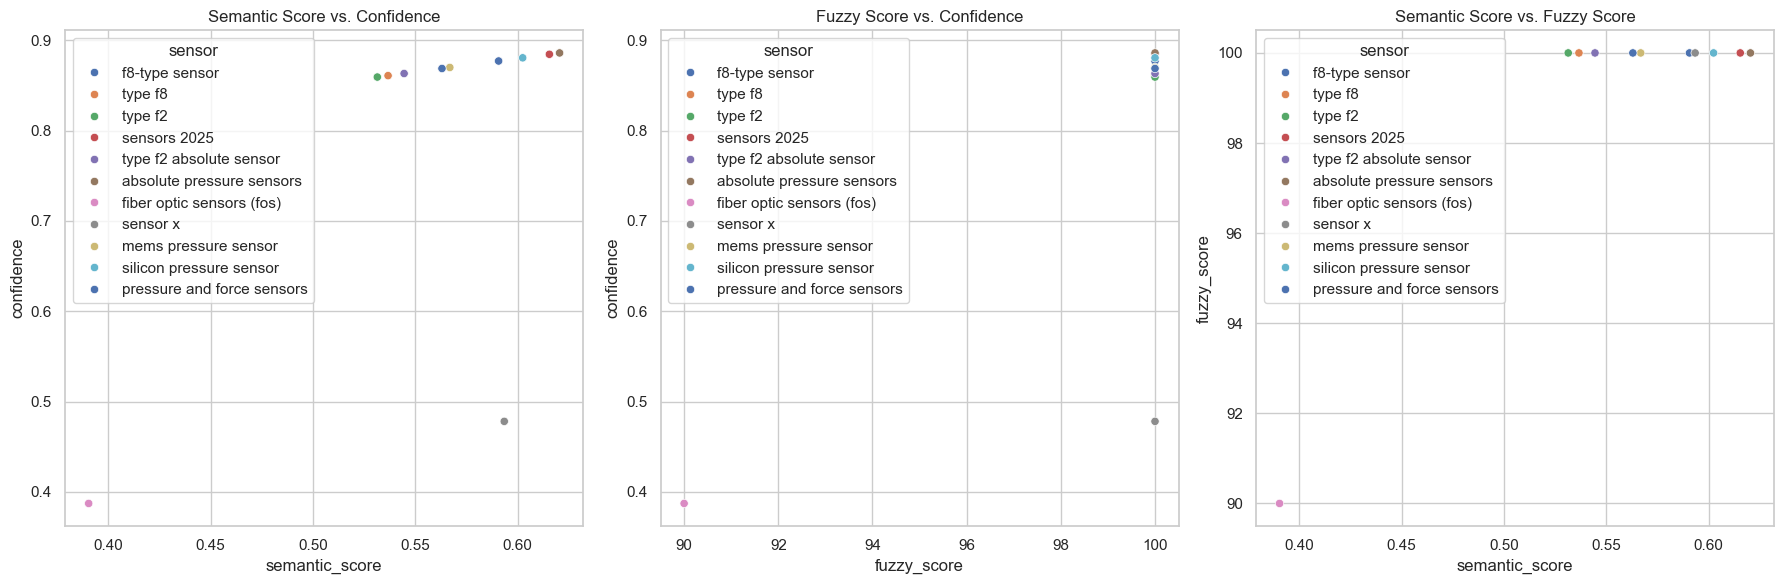

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

with open(validation_json_path, "r", encoding="utf-8") as f:
    owl_data = json.load(f)
# Convert to DataFrame
df = pd.DataFrame(owl_data)

# Set up the matplotlib figure
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Semantic Score vs. Confidence
sns.scatterplot(ax=axes[0], data=df, x="semantic_score", y="confidence", hue="sensor", palette="deep")
axes[0].set_title("Semantic Score vs. Confidence")

# Fuzzy Score vs. Confidence
sns.scatterplot(ax=axes[1], data=df, x="fuzzy_score", y="confidence", hue="sensor", palette="deep")
axes[1].set_title("Fuzzy Score vs. Confidence")

# Semantic Score vs. Fuzzy Score
sns.scatterplot(ax=axes[2], data=df, x="semantic_score", y="fuzzy_score", hue="sensor", palette="deep")
axes[2].set_title("Semantic Score vs. Fuzzy Score")

plt.tight_layout()
plt.show()